In [93]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from run_split import SplitMnistGenerator, SplitMnistRandomGenerator
from run_permuted import PermutedMnistGenerator
from alg.cla_models_multihead import MFVI_NN, Vanilla_NN
from alg.HIBP_BNN_multihead import HIBP_BNN
from alg.IBP_BNN_multihead import IBP_BNN
from hibp_weight_pruning import prune_weights, MnistGenerator
from alg.utils import get_scores, concatenate_results, get_uncertainties
from alg.vcl import run_vcl
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Split MNIST

In [94]:
hidden_size = [100]
batch_size = 128
no_epochs = 100
run = 2
val = False
#data_gen = SplitMnistRandomGenerator(val)
data_gen = SplitMnistGenerator(val)
all_acc = np.array([])
all_uncerts_split, accs = {}, {}
all_x_testsets, all_y_testsets = [], []
x_testsets, y_testsets = [], []

for task_id in range(data_gen.max_iter):
    np.random.seed(1)
    if val:
        _, _, x_test, y_test, _, _ = data_gen.next_task()
    else:
        _, _, x_test, y_test = data_gen.next_task()
    all_x_testsets.append(x_test)
    all_y_testsets.append(y_test)

data_gen.reset_cur_iter()
coreset_size = 0
single_head=False
in_dim, out_dim = data_gen.get_dims()
for task_id in range(data_gen.max_iter):

    tf.reset_default_graph()  
    tf.set_random_seed(1)
    np.random.seed(1)
    if val:
        x_train, y_train, x_test, y_test, _, _ = data_gen.next_task()
    else:
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size

    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 10, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    model = IBP_BNN(input_size=in_dim, 
                     hidden_size=hidden_size, 
                     output_size=out_dim, 
                     training_size=x_train.shape[0], 
                     no_train_samples=10,
                     no_pred_samples=100,
                     num_ibp_samples=10, prev_means=mf_weights, 
                     prev_log_variances=mf_variances, 
                     prev_betas=mf_betas,
                     learning_rate=0.001, learning_rate_decay=0.87,
                     prior_mean=0.0, prior_var=0.7,
                     alpha0=5.0, beta0=1.0,
                     lambda_1=1.0, lambda_2=1.0,
                     tensorboard_dir='logs',
                     #name='ibp_rs_opt_split_random_noise_rs_l1_mh_run{0}_task{1}'.format(run, task_id+1),
                     name='split_normal_run{0}_split_normal_l1_mh_task{1}'.format(run, task_id+1),
                     #name='ibp_perm_run{0}_perm_l1_mh_new_task{1}'.format(run, task_id+1),
                     use_local_reparam=False, implicit_beta=True)
    # graph_split_normal_run3_split_normal_l1_mh_task4
    # graph_ibp_rs_opt_split_random_noise_rs_l1_mh_run1_task1
    # graph_ibp_perm_run1_perm_l1_mh_new_task1
    model.create_model()
    #model.restore(os.path.join("logs_rs", 'graph_ibp_rs_opt_{0}'.format('split_random_noise_rs_l1_mh_run{0}_task{1}'.format(run, task_id+1))))
    model.restore(model.log_folder)
    
    mf_weights, mf_variances, mf_betas = model.get_weights()
    
    uncert = get_uncertainties(model, all_x_testsets, all_y_testsets, single_head, task_id, bsize)
    acc = get_scores(model, all_x_testsets, all_y_testsets, bsize, single_head)
    accs[task_id] = acc
    all_uncerts_split[task_id] = uncert
    
    _acc = get_scores(model, x_testsets, y_testsets, bsize, single_head)
    all_acc = concatenate_results(_acc, all_acc)
    
    model.close_session()

Epoch: 0001 cost= 0.053171204
Epoch: 0006 cost= 0.000736305
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_split_normal_run2_split_normal_l1_mh_task1/model.ckpt
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_split_normal_run2_split_normal_l1_mh_task2/model.ckpt
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_split_normal_run2_split_normal_l1_mh_task3/model.ckpt
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_split_normal_run2_split_normal_l1_mh_task4/model.ckpt
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_split_normal_run2_split_normal_l1_mh_task5/model.ckpt


In [91]:
all_acc

array([[0.99828373,        nan,        nan,        nan,        nan],
       [0.98341912, 0.98114538,        nan,        nan,        nan],
       [0.84935648, 0.95827869, 0.99271315,        nan,        nan],
       [0.74509101, 0.94366411, 0.98578862, 0.99430176,        nan],
       [0.74928892, 0.93816045, 0.97380868, 0.9789752 , 0.98039559]])

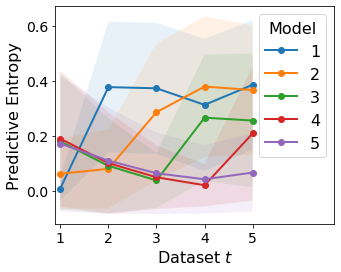

In [95]:
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
num_tasks = 5
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for i in range(num_tasks):
    ax.plot(np.arange(len(all_uncerts_split[i])) + 1, 
               [np.mean(all_uncerts_split[i][j]) for j in range(num_tasks)],
               label='{}'.format(i+1),
               marker='o', linewidth=lw)
    ax.fill_between(np.arange(len(all_uncerts_split[i])) + 1,
               [np.mean(all_uncerts_split[i][j]) - np.std(all_uncerts_split[i][j]) for j in range(num_tasks)],
               [np.mean(all_uncerts_split[i][j]) + np.std(all_uncerts_split[i][j]) for j in range(num_tasks)],
               alpha=0.1)
    ax.set_xticks(np.arange(len(all_uncerts_split[i])) + 1)
    ax.legend(fontsize=legend_size, title="Model", title_fontsize=legend_size, loc='upper right')
    ax.set_xlabel('Dataset $t$', fontsize=legend_size)
    ax.tick_params(labelsize=tick_size)
    ax.set_ylabel('Predictive Entropy', fontsize=legend_size)
    #ax[i].set_ylim(0.0, 2.0)
    ax.set_xlim(0.9, 6.7)
plt.show()

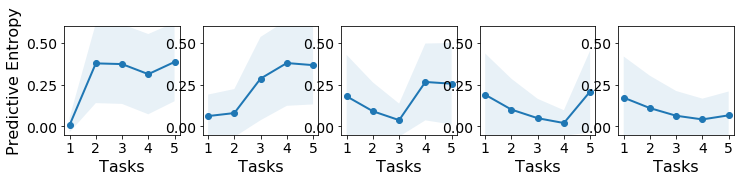

In [73]:
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
num_tasks = 5
fig, ax = plt.subplots(1, 5, figsize=(12, 2))
for i in range(num_tasks):
    ax[i].plot(np.arange(len(all_uncerts[i])) + 1, 
               [np.mean(all_uncerts[i][j]) for j in range(num_tasks)],
               label='Task {}'.format(i+1),
               marker='o', linewidth=lw)
    ax[i].fill_between(np.arange(len(all_uncerts[i])) + 1,
               [np.mean(all_uncerts[i][j]) - np.std(all_uncerts[i][j]) for j in range(num_tasks)],
               [np.mean(all_uncerts[i][j]) + np.std(all_uncerts[i][j]) for j in range(num_tasks)],
               alpha=0.1)
    ax[i].set_xticks(np.arange(len(all_uncerts[i])) + 1)
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].tick_params(labelsize=tick_size)
    ax[i].set_ylim(-0.05, 0.6)
    if i ==0:
        ax[i].set_ylabel('Predictive Entropy', fontsize=legend_size)
plt.show()

In [ ]:
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
num_tasks = 5
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
for i in range(num_tasks):
    ax.plot(np.arange(len(accs[i])) + 1, 
               [np.mean(accs[i][j]) for j in range(num_tasks)],
               label='Task {}'.format(i+1),
               marker='o', linewidth=lw)
    ax.set_xticks(np.arange(len(accs[i])) + 1)
    ax.legend(fontsize=legend_size)
    ax.set_xlabel('Tasks', fontsize=legend_size)
    ax.set_ylabel('Accs', fontsize=legend_size)
plt.show()

# Permuted MNIST

In [96]:
hidden_size = [100]
batch_size = 128
no_epochs = 100
run = 2
val = True
#data_gen = SplitMnistRandomGenerator(val)
#data_gen = SplitMnistGenerator(val)
data_gen = PermutedMnistGenerator(max_iter=5, val=val)
all_acc = np.array([])
all_uncerts_perm, accs = {}, {}
all_x_testsets, all_y_testsets = [], []
x_testsets, y_testsets = [], []

for task_id in range(data_gen.max_iter):
    np.random.seed(1)
    if val:
        _, _, x_test, y_test, _, _ = data_gen.next_task()
    else:
        _, _, x_test, y_test = data_gen.next_task()
    all_x_testsets.append(x_test)
    all_y_testsets.append(y_test)

data_gen.reset_cur_iter()
coreset_size = 0
single_head=False
in_dim, out_dim = data_gen.get_dims()
for task_id in range(data_gen.max_iter):

    tf.reset_default_graph()  
    tf.set_random_seed(1)
    np.random.seed(1)
    if val:
        x_train, y_train, x_test, y_test, _, _ = data_gen.next_task()
    else:
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size

    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 10, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    model = IBP_BNN(input_size=in_dim, 
                     hidden_size=hidden_size, 
                     output_size=out_dim, 
                     training_size=x_train.shape[0], 
                     no_train_samples=10,
                     no_pred_samples=100,
                     num_ibp_samples=10, prev_means=mf_weights, 
                     prev_log_variances=mf_variances, 
                     prev_betas=mf_betas,
                     learning_rate=0.001, learning_rate_decay=0.87,
                     prior_mean=0.0, prior_var=0.7,
                     alpha0=5.0, beta0=1.0,
                     lambda_1=1.0, lambda_2=1.0,
                     tensorboard_dir='logs_perm',
                     #name='ibp_rs_opt_split_random_noise_rs_l1_mh_run{0}_task{1}'.format(run, task_id+1),
                     #name='split_normal_run{0}_split_normal_l1_mh_task{1}'.format(run, task_id+1),
                     name='ibp_perm_run{0}_perm_l1_mh_new_task{1}'.format(run, task_id+1),
                     use_local_reparam=False, implicit_beta=True)
    # graph_split_normal_run3_split_normal_l1_mh_task4
    # graph_ibp_rs_opt_split_random_noise_rs_l1_mh_run1_task1
    # graph_ibp_perm_run1_perm_l1_mh_new_task1
    model.create_model()
    #model.restore(os.path.join("logs_rs", 'graph_ibp_rs_opt_{0}'.format('split_random_noise_rs_l1_mh_run{0}_task{1}'.format(run, task_id+1))))
    model.restore(model.log_folder)
    
    mf_weights, mf_variances, mf_betas = model.get_weights()
    
    uncert = get_uncertainties(model, all_x_testsets, all_y_testsets, single_head, task_id, bsize)
    acc = get_scores(model, all_x_testsets, all_y_testsets, bsize, single_head)
    accs[task_id] = acc
    all_uncerts_perm[task_id] = uncert
    
    _acc = get_scores(model, x_testsets, y_testsets, bsize, single_head)
    all_acc = concatenate_results(_acc, all_acc)
    
    model.close_session()

Epoch: 0001 cost= 0.460927513
Epoch: 0006 cost= 0.087805614
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs_perm/graph_ibp_perm_run2_perm_l1_mh_new_task1/model.ckpt
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs_perm/graph_ibp_perm_run2_perm_l1_mh_new_task2/model.ckpt
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs_perm/graph_ibp_perm_run2_perm_l1_mh_new_task3/model.ckpt
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs_perm/graph_ibp_perm_run2_perm_l1_mh_new_task4/model.ckpt
Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs_perm/graph_ibp_perm_run2_perm_l1_mh_new_task5/model.ckpt


In [97]:
all_acc

array([[0.95383109,        nan,        nan,        nan,        nan],
       [0.94994462, 0.93658129,        nan,        nan,        nan],
       [0.93994956, 0.92624505, 0.94067643,        nan,        nan],
       [0.93897844, 0.93002571, 0.93505241, 0.94038073,        nan],
       [0.93397449, 0.92504055, 0.91725573, 0.93454905, 0.94088014]])

In [98]:
acc

[0.9340071225468113,
 0.9250781234306623,
 0.9165812896776802,
 0.9345302611966679,
 0.9400375802305683]

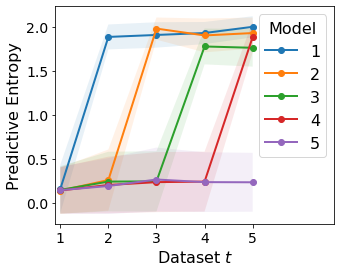

In [99]:
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
num_tasks = 5
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for i in range(num_tasks):
    ax.plot(np.arange(len(all_uncerts_perm[i])) + 1, 
               [np.mean(all_uncerts_perm[i][j]) for j in range(num_tasks)],
               label='{}'.format(i+1),
               marker='o', linewidth=lw)
    ax.fill_between(np.arange(len(all_uncerts_perm[i])) + 1,
               [np.mean(all_uncerts_perm[i][j]) - np.std(all_uncerts_perm[i][j]) for j in range(num_tasks)],
               [np.mean(all_uncerts_perm[i][j]) + np.std(all_uncerts_perm[i][j]) for j in range(num_tasks)],
               alpha=0.1)
    ax.set_xticks(np.arange(len(all_uncerts_perm[i])) + 1)
    ax.legend(fontsize=legend_size, title="Model", title_fontsize=legend_size, loc='upper right')
    ax.set_xlabel('Dataset $t$', fontsize=legend_size)
    ax.tick_params(labelsize=tick_size)
    ax.set_ylabel('Predictive Entropy', fontsize=legend_size)
    #ax[i].set_ylim(0.0, 2.0)
    ax.set_xlim(0.9, 6.7)
plt.show()

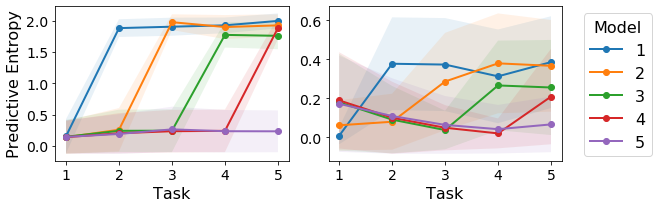

In [129]:
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
num_tasks = 5
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i in range(num_tasks):
    ax[0].plot(np.arange(len(all_uncerts_perm[i])) + 1, 
               [np.mean(all_uncerts_perm[i][j]) for j in range(num_tasks)],
               marker='o', linewidth=lw)
    ax[0].fill_between(np.arange(len(all_uncerts_perm[i])) + 1,
               [np.mean(all_uncerts_perm[i][j]) - np.std(all_uncerts_perm[i][j]) for j in range(num_tasks)],
               [np.mean(all_uncerts_perm[i][j]) + np.std(all_uncerts_perm[i][j]) for j in range(num_tasks)],
               alpha=0.1)
    ax[0].set_xticks(np.arange(len(all_uncerts_perm[i])) + 1)
    ax[0].set_xlabel('Task', fontsize=legend_size)
    ax[0].tick_params(labelsize=tick_size)
    ax[0].set_ylabel('Predictive Entropy', fontsize=legend_size)
#ax[i].set_ylim(0.0, 2.0)
#ax.set_xlim(0.9, 6.7)
for i in range(num_tasks):
    ax[1].plot(np.arange(len(all_uncerts_split[i])) + 1, 
               [np.mean(all_uncerts_split[i][j]) for j in range(num_tasks)],
               label='{}'.format(i+1),
               marker='o', linewidth=lw)
    ax[1].fill_between(np.arange(len(all_uncerts_split[i])) + 1,
               [np.mean(all_uncerts_split[i][j]) - np.std(all_uncerts_split[i][j]) for j in range(num_tasks)],
               [np.mean(all_uncerts_split[i][j]) + np.std(all_uncerts_split[i][j]) for j in range(num_tasks)],
               alpha=0.1)
    ax[1].set_xticks(np.arange(len(all_uncerts_split[i])) + 1)
    #ax[1].legend(fontsize=legend_size, title="Model", title_fontsize=legend_size, loc='upper right')
    ax[1].set_xlabel('Task', fontsize=legend_size)
    ax[1].tick_params(labelsize=tick_size)
    #ax[i].set_ylim(0.0, 2.0)
    #ax[1].set_xlim(0.8, 7.7)
fig.legend(fontsize=legend_size, title="Model", title_fontsize=legend_size, bbox_to_anchor=(1.0,0.57), loc="center left")
fig.tight_layout()
plt.savefig("plots/pred_entropy_ibp_perm_split.pdf", bbox_inches='tight')
plt.show()

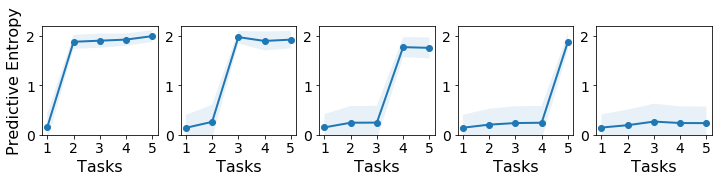

In [64]:
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
num_tasks = 5
fig, ax = plt.subplots(1, 5, figsize=(12, 2))
for i in range(num_tasks):
    ax[i].plot(np.arange(len(all_uncerts[i])) + 1, 
               [np.mean(all_uncerts[i][j]) for j in range(num_tasks)],
               label='Task {}'.format(i+1),
               marker='o', linewidth=lw)
    ax[i].fill_between(np.arange(len(all_uncerts[i])) + 1,
               [np.mean(all_uncerts[i][j]) - np.std(all_uncerts[i][j]) for j in range(num_tasks)],
               [np.mean(all_uncerts[i][j]) + np.std(all_uncerts[i][j]) for j in range(num_tasks)],
               alpha=0.1)
    ax[i].set_xticks(np.arange(len(all_uncerts[i])) + 1)
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].tick_params(labelsize=tick_size)
    ax[i].set_ylim(0.0, 2.2)
    if i ==0:
        ax[i].set_ylabel('Predictive Entropy', fontsize=legend_size)
plt.show()

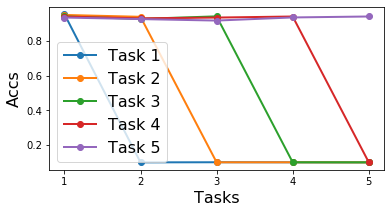

In [56]:
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
num_tasks = 5
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
for i in range(num_tasks):
    ax.plot(np.arange(len(accs[i])) + 1, 
               [np.mean(accs[i][j]) for j in range(num_tasks)],
               label='Task {}'.format(i+1),
               marker='o', linewidth=lw)
    ax.set_xticks(np.arange(len(accs[i])) + 1)
    ax.legend(fontsize=legend_size)
    ax.set_xlabel('Tasks', fontsize=legend_size)
    ax.set_ylabel('Accs', fontsize=legend_size)
plt.show()

# VCL

In [ ]:
hidden_size = [100]
batch_size = 128
no_epochs = 100
run = 2
val = False
#data_gen = SplitMnistRandomGenerator(val)
data_gen = SplitMnistGenerator(val)
all_acc = np.array([])
all_uncerts_split, accs = {}, {}
all_x_testsets, all_y_testsets = [], []
x_testsets, y_testsets = [], []

for task_id in range(data_gen.max_iter):
    np.random.seed(1)
    if val:
        _, _, x_test, y_test, _, _ = data_gen.next_task()
    else:
        _, _, x_test, y_test = data_gen.next_task()
    all_x_testsets.append(x_test)
    all_y_testsets.append(y_test)

data_gen.reset_cur_iter()
coreset_size = 0
single_head=False
in_dim, out_dim = data_gen.get_dims()
for task_id in range(data_gen.max_iter):

    tf.reset_default_graph()  
    tf.set_random_seed(1)
    np.random.seed(1)
    if val:
        x_train, y_train, x_test, y_test, _, _ = data_gen.next_task()
    else:
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size

    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 10, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()
    
    #graph_vcl_perm_h50_perm_l1_mh_run2_task1
    # Train on non-coreset data
    mf_model = MFVI_NN(in_dim, hidden_size, out_dim, x_train.shape[0], 
                       prev_means=mf_weights, 
                       prev_log_variances=mf_variances,
                       name="{0}_task{1}".format(name, task_id+1), 
                       tensorboard_dir='logs_perm',
                       use_local_reparam=False)


    # Train on non-coreset data
    model = IBP_BNN(input_size=in_dim, 
                     hidden_size=hidden_size, 
                     output_size=out_dim, 
                     training_size=x_train.shape[0], 
                     no_train_samples=10,
                     no_pred_samples=100,
                     num_ibp_samples=10, prev_means=mf_weights, 
                     prev_log_variances=mf_variances, 
                     prev_betas=mf_betas,
                     learning_rate=0.001, learning_rate_decay=0.87,
                     prior_mean=0.0, prior_var=0.7,
                     alpha0=5.0, beta0=1.0,
                     lambda_1=1.0, lambda_2=1.0,
                     tensorboard_dir='logs',
                     #name='ibp_rs_opt_split_random_noise_rs_l1_mh_run{0}_task{1}'.format(run, task_id+1),
                     name='split_normal_run{0}_split_normal_l1_mh_task{1}'.format(run, task_id+1),
                     #name='ibp_perm_run{0}_perm_l1_mh_new_task{1}'.format(run, task_id+1),
                     use_local_reparam=False, implicit_beta=True)
    # graph_split_normal_run3_split_normal_l1_mh_task4
    # graph_ibp_rs_opt_split_random_noise_rs_l1_mh_run1_task1
    # graph_ibp_perm_run1_perm_l1_mh_new_task1
    model.create_model()
    #model.restore(os.path.join("logs_rs", 'graph_ibp_rs_opt_{0}'.format('split_random_noise_rs_l1_mh_run{0}_task{1}'.format(run, task_id+1))))
    model.restore(model.log_folder)
    
    mf_weights, mf_variances, mf_betas = model.get_weights()
    
    uncert = get_uncertainties(model, all_x_testsets, all_y_testsets, single_head, task_id, bsize)
    acc = get_scores(model, all_x_testsets, all_y_testsets, bsize, single_head)
    accs[task_id] = acc
    all_uncerts_split[task_id] = uncert
    
    _acc = get_scores(model, x_testsets, y_testsets, bsize, single_head)
    all_acc = concatenate_results(_acc, all_acc)
    
    model.close_session()